# Regression solution using Pycaret

## 1.0 - Libraries & Functions

In [1]:
# data extraction & manipulation
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing and modeling
from pycaret.regression import (
    setup, create_model, compare_models, plot_model,
    get_config, evaluate_model, predict_model
)
from pycaret.utils import check_metric

## 2.0 - Data extraction

In [2]:
df = pd.read_csv('datasets/volkswagen.csv')

In [3]:
# spliting data train and test validation
df_train = df.sample(frac=0.95, random_state=786)
df_test = df.drop(df_train.index, axis=0)

df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [4]:
df_train.shape, df_test.shape

((14399, 9), (758, 9))

## 3.0 - Data Analysis

In [93]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5


In [6]:
print(f'rows and columns: {df_train.shape}')
cols = df_train.columns
top = [df_train[col].value_counts().reset_index().loc[0, 'index'] for col in cols]
desc = pd.concat([
    df_train.dtypes,
    df_train.isna().mean() * 100,
    df_train.nunique(),
    df_train.mean(),
    df_train.std(),
    df_train.min(),
    df_train.max(),
    df_train.sample(4).T
    ], axis=1
).round(2)
cols = ['dtypes', '%_null', 'unique', 'mean', 'std',
    'min', 'max', 0, 1, 2,3]
desc.columns = cols
desc

rows and columns: (14399, 10)


,dtypes,%_null,unique,mean,std,min,max,0,1,2,3
index,int64,0.0,14399,7581.31,4371.47,0,15155,367,8267,14359,2992
model,object,0.0,27,NaN,NaN,Amarok,Up,T-Roc,Polo,Touran,Golf
year,int64,0.0,21,2017.25,2.06,2000,2020,2018,2017,2011,2013
price,int64,0.0,3856,16809.87,7736.91,899,69994,19595,9490,7995,6991
transmission,object,0.0,3,NaN,NaN,Automatic,Semi-Auto,Manual,Manual,Semi-Auto,Manual
mileage,int64,0.0,10307,22109.31,21155.37,1,212000,8554,22952,63700,69711
fuelType,object,0.0,4,NaN,NaN,Diesel,Petrol,Diesel,Petrol,Diesel,Diesel
tax,int64,0.0,32,112.63,63.47,0,580,145,20,165,0
mpg,float64,0.0,86,53.77,13.63,0.3,188.3,50.4,60.1,49.6,74.3
engineSize,float64,0.0,12,1.60,0.46,0.0,3.2,1.6,1.0,2.0,1.6


In [57]:
df_train['year'].value_counts()

2019    4428
2017    2812
2016    2499
2018    1427
2015    1105
2020     995
2014     558
2013     294
2012      79
2011      55
2010      40
2009      30
2008      25
2007      19
2006      14
2005       8
2001       4
2004       3
2003       2
2000       1
2002       1
Name: year, dtype: int64

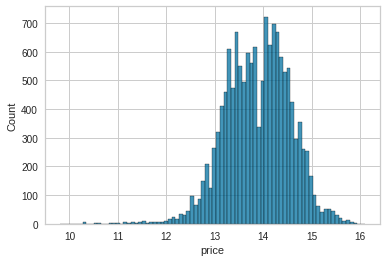

In [75]:
sns.histplot(np.log2(df_train['price']));

## 4.0 - Setup (Preprocessing and Modeling)

In [34]:
df_train['year_sin'] = df_train['year'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df_train['year_cos'] = df_train['year'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

In [84]:
set_model = setup(
    data=df_train,
    target='price',
    session_id=123,
    n_jobs=2,
    #ignore_features=['index', 'year_sin', 'year_cos'],
    #numeric_features=['mileage', 'mpg'],
    #ordinal_features={
    #    "engineSize":[
    #        0.0, 1.0, 1.2, 1.4, 1.5, 1.6,
    #        1.8, 1.9, 2.0, 2.5, 3.0, 3.2
    #    ]
    #},
    #categorical_features=[
    #    'model', 'transmission', 'fuelType', 'year', 'engineSize'],
    transform_target=True,
    normalize=True,
    #remove_outliers=True,
    ignore_low_variance=True,
    combine_rare_levels=True,
    rare_level_threshold=0.3,
    bin_numeric_features=['tax']
)

,Description,Value
0,session_id,123
1,Target,price
2,Original Data,"(14399, 9)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(10079, 59)"


In [85]:
get_config("X_train").head()

,mileage,mpg,engineSize,model_ Amarok,model_ Arteon,model_ Beetle,model_ CC,model_ Caravelle,model_ Golf,model_ Golf SV,...,tax_13.0,tax_14.0,tax_2.0,tax_3.0,tax_4.0,tax_5.0,tax_6.0,tax_7.0,tax_8.0,tax_9.0
3933,0.573718,0.377724,0.874732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2124,1.388823,1.121089,0.005691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9681,-0.055714,-0.038560,-0.428830,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5927,-1.040123,-0.313605,0.005691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3488,-0.933170,-0.997500,-0.211570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,1098.3941,2645087.0383,1624.9859,0.9552,0.0992,0.0689,1.4930
lightgbm,Light Gradient Boosting Machine,1151.6678,3104822.8683,1760.1138,0.9475,0.1035,0.0718,0.1560
rf,Random Forest Regressor,1151.4336,3181441.9554,1780.2091,0.9462,0.1099,0.0742,1.9150
knn,K Neighbors Regressor,1200.4988,3390189.1960,1838.6449,0.9427,0.1130,0.0780,0.1530
et,Extra Trees Regressor,1161.6180,3420886.8987,1840.4856,0.9422,0.1089,0.0735,1.9650
gbr,Gradient Boosting Regressor,1518.2641,4692698.0620,2165.6264,0.9205,0.1263,0.0955,0.7460
dt,Decision Tree Regressor,1416.7370,5030327.7732,2238.5862,0.9149,0.1370,0.0909,0.0680
br,Bayesian Ridge,1507.8615,5046402.0220,2244.7874,0.9146,0.1207,0.0900,0.1040
ridge,Ridge Regression,1508.2690,5069152.5115,2249.7676,0.9142,0.1206,0.0900,0.0550
huber,Huber Regressor,1497.1841,5416282.5372,2323.0229,0.9084,0.1216,0.0887,0.8530


In [87]:
model = create_model(estimator=best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1043.6751,2337036.8950,1528.7370,0.9612,0.0972,0.0672
1,1079.7974,2444578.8480,1563.5149,0.9577,0.1042,0.0668
2,1152.2091,2827419.8907,1681.4934,0.9538,0.0918,0.0673
3,1161.0447,2867653.8292,1693.4148,0.9551,0.1089,0.0755
4,1118.3610,2668367.8582,1633.5140,0.9535,0.1162,0.0754
5,1078.2240,2546560.6289,1595.7947,0.9527,0.1011,0.0699
6,1104.1918,2849237.0818,1687.9683,0.9536,0.0922,0.0673
7,1067.2138,2406315.4984,1551.2303,0.9570,0.0865,0.0641
8,1083.0712,2497634.3806,1580.3906,0.9589,0.0902,0.0655


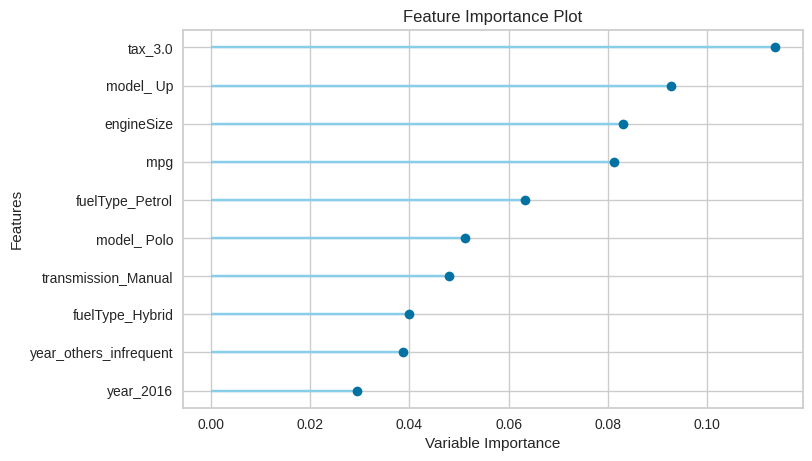

In [88]:
plot_model(estimator=model, plot='feature')

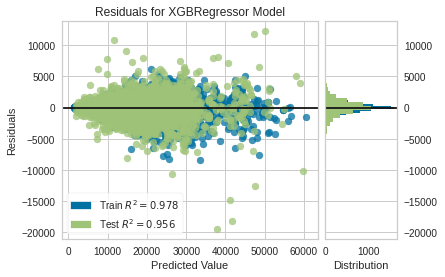

In [89]:
# 0.977-0.912, 0.978-0.902
plot_model(estimator=model)

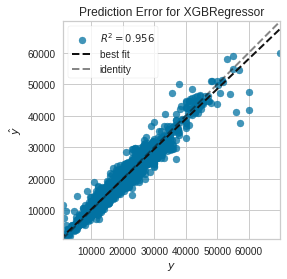

In [90]:
# 0.912, 0.902
plot_model(estimator=model, plot='error')

In [91]:
# 0.8835, 0.9010
pred = predict_model(estimator=model, data=df_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,1055.3320,2166044.1517,1471.7487,0.9668,0.0899,0.0649
